# Bank Marketing: Our Data and Approach

The setting and goal of our Dataset was already described:  
  
Setting:  
_"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed."_  

Goal:  
_"The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y)."_  

## Nature of Data
First we looked at the Nature of the Data.  
[Nature of Data](Nature_of_Data_NEW.ipynb)  

Important findings were:  
  
  

## Testing different classification models
As first approach to learning, we tried diferent models.  
We used a grid search to compare different classifiers as well as there paramters. We improved the code throughout the process and ended up with a quite comprehensive grid, that helped us sort aut, which classifier might be the best for our data and goal.



### Preprocessing
Before we did that however, we started by preprocessing the Data.
First, we imported the Data. There is a smaller Dataset with around 10% included in the Data, that we decided to use for the research process. (So we had more reasonable processing times)

Afterwards, we prepared the Data and encoded it, using a OneHot Encoder as well as a MinMaxScaler.


In [13]:
# For installation, uncomment the following installation instructions

# !pip install pandas numpy seaborn matplotlib scikit-learn imbalanced-learn


import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler




In [14]:
bank_data = pd.read_csv("Data/bank-additional/bank-additional/bank-additional.csv", delimiter=";") #10 % of examples

bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [15]:
# Preprocessing of the target data
bank_target = bank_data['y']
bank_data = bank_data.drop(columns='y')

label = LabelEncoder()
bank_target = label.fit_transform(bank_target)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])
print(bank_target)

[0 0 0 ... 0 0 0]


### Pipelines:
We prepared some pipleines, to be able to do the preprocessing dynamically within the Cross-Validation Grid search. 

In [21]:
# decision tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', DecisionTreeClassifier())])

# random forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', RandomForestClassifier())])

# k nearest neighbours
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', KNeighborsClassifier())])

# multinomial naive bayes
mnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', MultinomialNB())])

# gaussian naive bayes
gnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', GaussianNB())])

# neural Network, MLP classifier
nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=13)),
                              ('classifier', MLPClassifier())])

### Grid Search Parameters:
As next step, we set the paramters that we wanted to try for the models tested in the CV Grid Search

In [33]:
dt_param_grid =  { 'classifier__criterion':['gini','entropy'],
                   'classifier__max_depth': np.arange(3, 30),
                   'classifier__random_state': [13]}

rf_param_grid =  {'classifier__n_estimators': [50, 100, 200, 500],
                  'classifier__max_features': ['sqrt','log2'], 
                  'classifier__max_depth' : [4,5,6,7,8,10,12,18,24],
                  'classifier__criterion' :['gini', 'entropy'],
                  'classifier__random_state': [13]}

knn_param_grid = {'classifier__n_neighbors': [3,5,10,15,20,25,30,40,50],
                  'classifier__weights': ['uniform', 'distance'],
                  'classifier__metric': ['euclidean', 'manhattan']}

mnb_param_grid = {'classifier__alpha': [0.5, 1.0, 1.5, 2.0],
                  'classifier__fit_prior': [True, False]}

gnb_param_grid = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

nn_param_grid = {'classifier__max_iter': [100, 250, 500],
                 'classifier__hidden_layer_sizes': [(50,50,50), (100,100,100)],
                 'classifier__activation': ['tanh', 'relu'],
                 'classifier__solver': ['sgd', 'adam'],
                 'classifier__alpha': [0.005, 0.05],
                 'classifier__learning_rate': ['constant','adaptive'],
                 'balancing__replacement': [True, False],
                  'classifier__random_state': [13]}

### Cost considerations
We choose the potential cost of the model as key metric/scorer for the grid search, to maximize the potential utility.

We thought about potential cost for each potential prediction outcome:  

- Predicting a subscription that happens (`1`, `1`) results in a benefit of 120 units. This reflects the profit from the actual subscription after deducting resource expenses.

- Predicting a non-subscription when the person subscribes (`0`, `1`) incurs a cost of 100 units, indicating a missed profit opportunity due to an incorrect prediction.

- Predicting a subscription that doesn't happen (`1`, `0`) incurs a cost of 40 units, for the resources spent on marketing to a non-subscriber.

- Predicting a non-subscription that holds true (`0`, `0`) has no cost.


#### Cost Matrix:
| Predict\Actual  | Subscribe (1) | Not Subscribe (0)    |
|-----------------|---------------|----------------------|
| Subscribe (1)   | 120 (Benefit)| 40 (Cost: Marketing) |
| Not Subscribe (0)| 100 (Cost: Lost Deal) | 0 (No Cost)|

#### Cost function
From the cost Matrix, we formed a corresponsing cost function.

In [29]:
def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=label_order)    
    return cm[0][0] * 0 + cm[0][1] * 40 - cm[1][1] * 120 + cm[1][0] * 100

scorer = make_scorer(cost_function, greater_is_better=False)

## Predict:
After these pre considerations, we did a large grid-search to compare both, multiple estimators as well as multiple parameters.

c:\Users\I568830\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


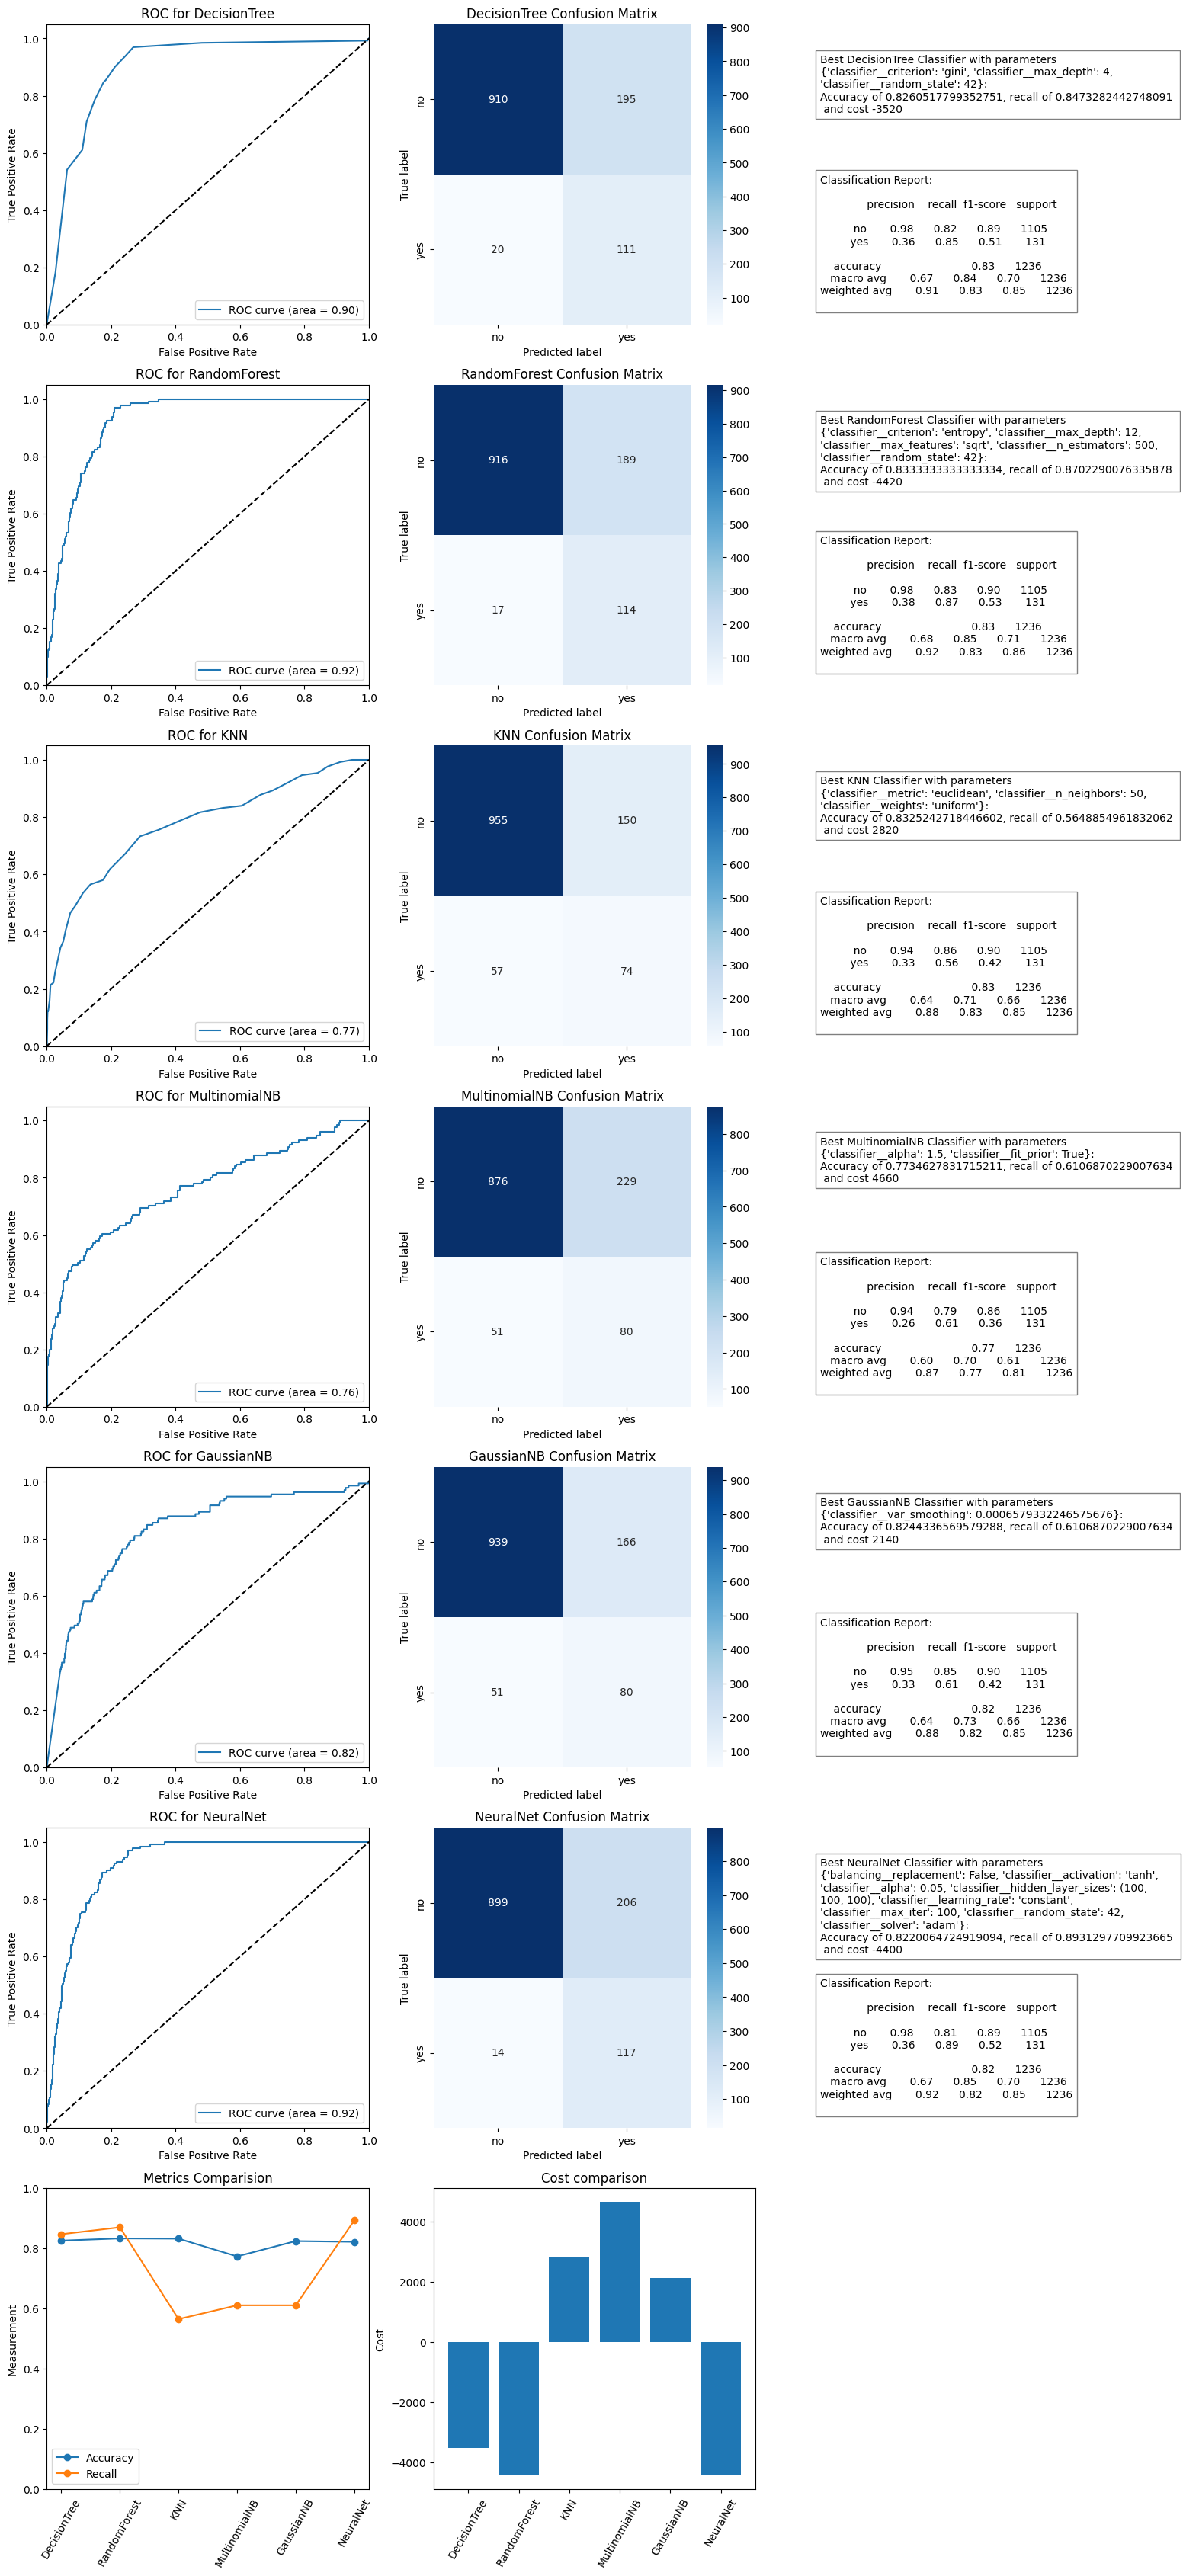

In [34]:

# list of tuples where the first element is the classifier's name, the second is the classifier itself and the third are the grid search parameters
classifiers = [('DecisionTree', dt_pipeline, dt_param_grid),
               ('RandomForest', rf_pipeline, rf_param_grid),
               ('KNN', knn_pipeline, knn_param_grid),
               ('MultinomialNB', mnb_pipeline, mnb_param_grid),
               ('GaussianNB', gnb_pipeline, gnb_param_grid),
               ('NeuralNet', nn_pipeline, nn_param_grid)
               ]


# Initialize lists to store classifier names and their performances
names = []
accuracies = []
recalls = []
costs = []

fig, axs = plt.subplots(len(classifiers)+1, 2, figsize=(12, (len(classifiers)+1) * 6))


# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.3, random_state=13)

# Loop over the classifiers
for i, (name, pipeline, param_grid) in enumerate(classifiers):
    # Grid search with parameter grid and cost function
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
    grid_search.fit(bank_data_train, bank_target_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Get the best parameters
    best_param = grid_search.best_params_
    
    # Make predictions with the best model
    prediction = best_model.predict(bank_data_test)

    # Calculate probabilities for the positive class
    probs = best_model.predict_proba(bank_data_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(bank_target_test, probs)
    
    # Calculate the AUC
    roc_auc = roc_auc_score(bank_target_test, probs)
    
    # Plot the ROC curve
    axs[i, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[i, 0].plot([0, 1], [0, 1], 'k--')
    axs[i, 0].set_xlim([0.0, 1.0])
    axs[i, 0].set_ylim([0.0, 1.05])
    axs[i, 0].set_xlabel('False Positive Rate')
    axs[i, 0].set_ylabel('True Positive Rate')
    axs[i, 0].set_title('ROC for {}'.format(name))
    axs[i, 0].legend(loc="lower right")

    # Calculate acc, recall, cost
    cm = confusion_matrix(bank_target_test, prediction)
    acc = accuracy_score(bank_target_test, prediction)
    recall = recall_score(bank_target_test, prediction) #yes recall
    cost = cost_function(bank_target_test, prediction)

    # Append them to list
    names.append(name)
    accuracies.append(acc)
    costs.append(cost)
    recalls.append(recall)

    # Plot Confusion Matrix for each classifier
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i, 1], xticklabels=label_names, yticklabels=label_names)
    axs[i, 1].set_title('{} Confusion Matrix'.format(name))
    axs[i, 1].set_xlabel('Predicted label')
    axs[i, 1].set_ylabel('True label')

    axs[i, 1].text(1.5, 0.9, "Best {} Classifier with parameters\n".format(name) + textwrap.fill(str(best_param), width=70) + ": \nAccuracy of {}, recall of {} \n and cost {}".format(acc, recall, cost), horizontalalignment='left', verticalalignment='top', transform=axs[i, 1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(1.5, 0.5, "Classification Report:\n\n{}".format(classification_report(bank_target_test, prediction, target_names=label_names), width=70), horizontalalignment='left', verticalalignment='top', transform=axs[i, 1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Plotting comparison

# Subplot for accuracy
# plt.subplot(121)  # 1 row, 2 columns, plot 1
axs[len(classifiers), 0].plot(names, accuracies, marker='o', label="Accuracy")
axs[len(classifiers), 0].plot(names, recalls, marker='o', label="Recall")
axs[len(classifiers), 0].set_title('Metrics Comparision')
axs[len(classifiers), 0].set_ylabel('Measurement')
axs[len(classifiers), 0].legend()
axs[len(classifiers), 0].set_ylim([0,1])
axs[len(classifiers), 0].tick_params(axis='x', rotation=60) # rotates x-axis labels 45 degrees

# Subplot for cost
# plt.subplot(122)  # 1 row, 2 columns, plot 2
axs[len(classifiers), 1].bar(names, costs)
axs[len(classifiers), 1].set_title('Cost comparison')
axs[len(classifiers), 1].set_ylabel('Cost')
axs[len(classifiers), 1].tick_params(axis='x', rotation=60, )  # rotates x-axis labels 45 degrees

plt.show()

## Further optimization of Random Forest

We found the Random Forest to be the most promising model. The Deision Tree apeared to be better some times bu tvaried greatly depending 

In [20]:

#extending param grid for RF
param_grid = {
    'balancing': [RandomOverSampler(), RandomUnderSampler()],
    'classifier__n_estimators': [50, 100, 200, 300, 400],
    'classifier__max_features': ['sqrt', 'log2'],
   'classifier__max_depth': [4,5,6,7,8,10,12,18,24,30, None],
#    'classifier__min_samples_split': [2, 5, 10],
#    'classifier__min_samples_leaf': [1, 2, 4],
   'classifier__bootstrap': [True, False],
   'classifier__criterion': ['gini', 'entropy']
}


# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.3, random_state=13)

# Grid search with parameter grid and cost function
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
grid_search.fit(bank_data_train, bank_target_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the best parameters
best_param = grid_search.best_params_

# Make predictions with the best model
prediction = best_model.predict(bank_data_test)

# Calculate probabilities for the positive class
probs = best_model.predict_proba(bank_data_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_test, probs)

# Calculate accuracy and cost
cm = confusion_matrix(bank_target_test, prediction)
acc = accuracy_score(bank_target_test, prediction)
recall = recall_score(bank_target_test, prediction) #yes recall
cost = cost_function(bank_target_test, prediction)

# Prepare Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC for {}'.format(name))
axs[0].legend(loc="lower right")


# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=label_names, yticklabels=label_names)
axs[1].set_title('{} Confusion Matrix'.format(name))
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')

plt.show()

print("Best Random Forest Classifier with parameters".format(name) + str(best_param) + ": \nAccuracy of {}, recall of {} and cost {}\n".format(acc, recall, cost))
print("Classification Report:\n\n{}".format(classification_report(bank_target_test, prediction, target_names=label_names)))




KeyboardInterrupt: 

### Training most promissing Model on big Dataset

#### Preprocessing the full Dataset:

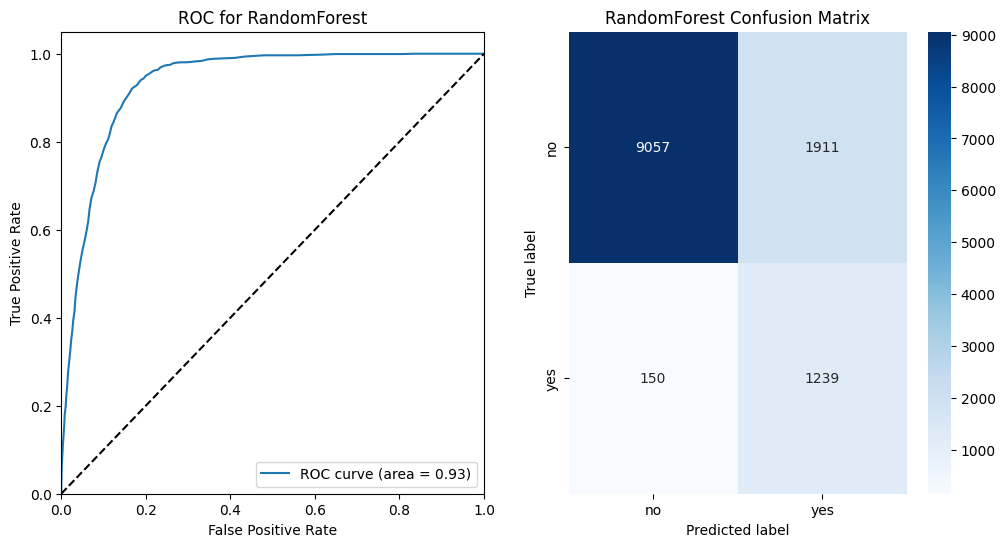

Best Random Forest Classifier with parameters{'balancing': RandomUnderSampler(), 'classifier__criterion': 'gini'}: 
Accuracy of 0.833211944646759, recall of 0.8920086393088553 and cost -57240

Classification Report:

              precision    recall  f1-score   support

          no       0.98      0.83      0.90     10968
         yes       0.39      0.89      0.55      1389

    accuracy                           0.83     12357
   macro avg       0.69      0.86      0.72     12357
weighted avg       0.92      0.83      0.86     12357



In [ ]:
#load full datast
bank_data_full = pd.read_csv("Data/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";") 

# Preprocessing of the target data
bank_target_f = bank_data_full['y']
bank_data_f = bank_data_full.drop(columns='y')

label = LabelEncoder()
bank_target_f = label.fit_transform(bank_target_f)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])

# creating a new pipeline
new_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', RandomForestClassifier(
                                  criterion='entropy', 
                                  max_depth=7, 
                                  max_features='sqrt', 
                                  n_estimators=100
                              ))])

# split into test and training data
bank_data_f_train, bank_data_f_test, bank_target_f_train, bank_target_f_test = train_test_split(bank_data_f, bank_target_f, test_size=0.3, random_state=13)

# Create and fit model
new_pipeline.fit(bank_data_f_train, bank_target_f_train)

# Make predictions
prediction = new_pipeline.predict(bank_data_f_test)

# Calculate probabilities for the positive class
probs = best_model.predict_proba(bank_data_f_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_f_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_f_test, probs)

# Calculate accuracy and cost
cm = confusion_matrix(bank_target_f_test, prediction)
acc = accuracy_score(bank_target_f_test, prediction)
recall = recall_score(bank_target_f_test, prediction) #yes recall
cost = cost_function(bank_target_f_test, prediction)

# Prepare Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC for {}'.format(name))
axs[0].legend(loc="lower right")


# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=label_names, yticklabels=label_names)
axs[1].set_title('{} Confusion Matrix'.format(name))
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')

plt.show()

print("Best Random Forest Classifier with parameters".format(name) + str(best_param) + ": \nAccuracy of {}, recall of {} and cost {}\n".format(acc, recall, cost))
print("Classification Report:\n\n{}".format(classification_report(bank_target_f_test, prediction, target_names=label_names)))
